In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms

In [2]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device) My laptop uses cpu
torch.manual_seed(2023)

#Download MNIST dataset in local system
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
                ]),
#    transform = ToTensor(), 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
                ]),
)


Batch size is 100

In [3]:
torch.manual_seed(2023)
loaders = {
    'train' :   torch.utils.data.DataLoader(train_data,
                                            batch_size = 100,
                                            shuffle=True
                                           ),
    'test'  :   torch.utils.data.DataLoader(test_data,
                                            batch_size = 100,
                                            shuffle=True
                                            )
}

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # fully connected layer, output 10 classes
        self.fc1 = nn.Linear(32 * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x   # return x for visualization

In [64]:
def calc_loss_acc(model, loader, loss_func):
    correct = 0
    total = 0
    loss_total = 0
    Count = 0
    with torch.no_grad():
        for batch in loader:
            image, label = batch
            output = model(image)
            loss = loss_func(output, label)
            loss_total +=loss
            Count +=1
            for i, out_y in enumerate(output):
                if torch.argmax(out_y) == label[i]:
                    correct +=1
                total +=1
    return loss_total / Count, round(correct/total, 3) # Return the loss and accuracy.

In [65]:
def train(model, optimizer, loaders, loss_func):
    model.train()
    for i, (image, label) in enumerate(loaders):
            b_x = Variable(image)
            b_y = Variable(label)
            optimizer.zero_grad()
            # or use data, target = Variable(images), Variable(labels)
            output = model(b_x)

            loss = loss_func(output, b_y)
            loss.backward()
            optimizer.step()

In [66]:
def set_optimizer(model, learning_rate):
    return torch.optim.Adam(model.parameters(), lr = learning_rate)

In [67]:
Loss_arr = []
Acc_arr = []

def get_result(model, epoch_num, optimizer):
    loss_func = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epoch_num + 1):
        train(model, optimizer, loaders['train'], loss_func)
        Train_loss, Train_acc = calc_loss_acc(model, loaders['train'], loss_func)
        Test_loss, Test_acc = calc_loss_acc(model, loaders['test'], loss_func)
        Loss_arr.append([Train_loss, Test_loss])
        Acc_arr.append([Train_acc, Test_acc])
        
        if epoch == 10:
            print("Model Train loss: ", Train_loss)
            print("Model Test loss: ", Test_loss)
    return Loss_arr, Acc_arr

In [68]:
loss_func = torch.nn.CrossEntropyLoss()
model1 = CNN()
optimizer = set_optimizer(model1, 0.001)
Loss, Acc = get_result(model1, 30, optimizer)

Model Train loss:  tensor(0.0161)
Model Test loss:  tensor(0.0354)


batch size is 600

In [72]:
param_batch_100 = torch.nn.utils.parameters_to_vector(model1.parameters()) 

In [69]:
torch.manual_seed(2023)
loaders = {
    'train' :   torch.utils.data.DataLoader(train_data,
                                            batch_size = 600,
                                            shuffle=True
                                           ),
    'test'  :   torch.utils.data.DataLoader(test_data,
                                            batch_size = 600,
                                            shuffle=True
                                            )
}

In [70]:
loss_func = torch.nn.CrossEntropyLoss()
model2 = CNN()
param_batch_600 = torch.nn.utils.parameters_to_vector(model2.parameters()) 
optimizer = set_optimizer(model2, 0.001)
Loss1, Acc1 = get_result(model2, 30, optimizer)

Model Train loss:  tensor(0.0342)
Model Test loss:  tensor(0.0341)


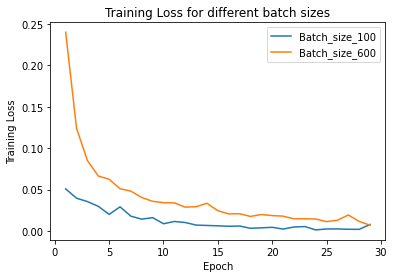

In [93]:
import matplotlib.pyplot as plt
L_100 = np.array(Loss[1:30])
A_100 = np.array(Acc[1:30])
L_600 = np.array(Loss1[30:-1])
A_600 = np.array(Acc1[30:-1])

epoch = np.arange(1, 30, 1)
plt.plot(epoch, L_100[:,0], label = 'Batch_size_100')
plt.plot(epoch, L_600[:,0], label = 'Batch_size_600')
plt.title('Training Loss for different batch sizes')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

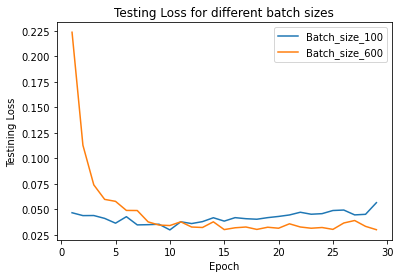

In [94]:
plt.plot(epoch, L_100[:,1], label = 'Batch_size_100')
plt.plot(epoch, L_600[:,1], label = 'Batch_size_600')
plt.title('Testing Loss for different batch sizes')
plt.xlabel('Epoch')
plt.ylabel('Testining Loss')
plt.legend()
plt.show()

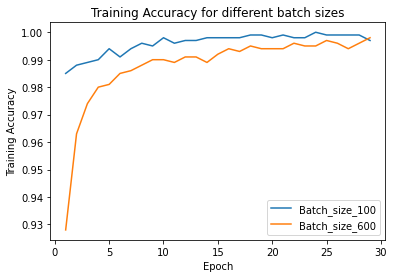

In [95]:
plt.plot(epoch, A_100[:,0], label = 'Batch_size_100')
plt.plot(epoch, A_600[:,0], label = 'Batch_size_600')
plt.title('Training Accuracy for different batch sizes')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

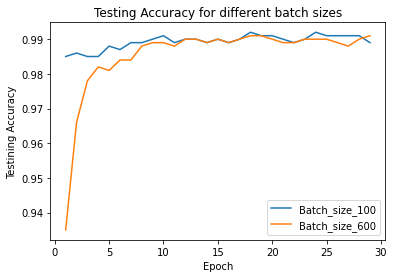

In [96]:
plt.plot(epoch, A_100[:,1], label = 'Batch_size_100')
plt.plot(epoch, A_600[:,1], label = 'Batch_size_600')
plt.title('Testing Accuracy for different batch sizes')
plt.xlabel('Epoch')
plt.ylabel('Testining Accuracy')
plt.legend()
plt.show()

In [97]:
alpha = np.arange(-1, 2, 0.2)
Theta = []
for i in range(len(alpha)):
    theta = (1-alpha[i])*param_batch_100 + alpha[i]*param_batch_600
    Theta.append(theta)

In [98]:
Alpha_train_LA = []
Alpha_test_LA = [] 

In [99]:
for i in range(len(Theta)):
    torch.manual_seed(2023)
    theta = Theta[i]
    model = CNN()
    torch.nn.utils.vector_to_parameters(theta, model.parameters())
    loss_func = nn.CrossEntropyLoss()

    loss, acc = calc_loss_acc(model, loaders['train'], loss_func)
    loss1, acc1 = calc_loss_acc(model, loaders['test'], loss_func) 
    Alpha_train_LA.append([loss, acc])
    Alpha_test_LA.append([loss1, acc1])
Train_LA = np.array(Alpha_train_LA)
Test_LA = np.array(Alpha_test_LA)

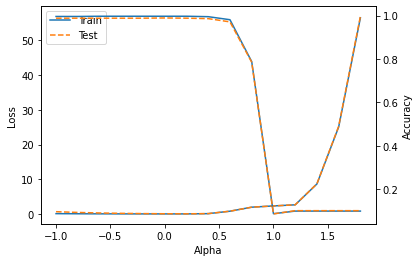

In [100]:
plt.plot(alpha, Train_LA[:, 0], label = 'Train')
plt.plot(alpha, Test_LA[:,0], label = 'Test', linestyle = 'dashed')
plt.xlabel('Alpha')
plt.ylabel('Loss')
plt.legend()

plt.twinx()
plt.plot(alpha, Train_LA[:,1])
plt.plot(alpha, Test_LA[:,1], linestyle = 'dashed')
plt.ylabel('Accuracy')
plt.show()

